<a href="https://colab.research.google.com/github/junaiskv94/Online-retail-segmentaion/blob/main/Capstone4_Online_retail_segmentaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:

# Importing required libraries
import numpy as np
# To handle the dataset
import pandas as pd

# For plots and visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
from yellowbrick.cluster import SilhouetteVisualizer

# For getting optimal number of clusters in hierarchical clustering
from scipy.cluster.hierarchy import dendrogram,linkage
# To scale the data
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# metrics to evaluate the clusters
from sklearn.metrics import silhouette_score, silhouette_samples
# Clustering alorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
# Display utilities
from IPython.display import Markdown, display
from datetime import datetime

# activating DND to disregard the warnings by goiing silent mode
import warnings
warnings.filterwarnings('ignore')

# setting default parameters for the plots
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["figure.dpi"] = 150

In [2]:

#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [123]:
#Reading the data
cus_data = pd.read_csv('/content/drive/MyDrive/capstone_project/4-Online retail segmentaion/Online Retail.xlsx - Online Retail.csv')

**Preliminary Data Inspection**

In [124]:
#First 5 observations of the dataframe
cus_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [125]:
# check for rows and columns
cus_data.shape

(541909, 8)

In [126]:

# summary of the dataset
cus_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [127]:

#A statistical description of the numerical features of dataset
cus_data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [128]:
# Checking number of unique values in each column
for col in cus_data.columns:
  print(col,':',cus_data[col].nunique())


InvoiceNo : 25900
StockCode : 4070
Description : 4223
Quantity : 722
InvoiceDate : 23260
UnitPrice : 1630
CustomerID : 4372
Country : 38


In [129]:
#Check for null values
cus_data.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [130]:
# Missing data counts and percentage
missing = cus_data.columns[cus_data.isnull().any()].tolist()
print('Missing Data Percentage')
print(round(cus_data[missing].isnull().sum().sort_values(ascending = False)/len(cus_data)*100,2))

Missing Data Percentage
CustomerID     24.93
Description     0.27
dtype: float64




*   24.93% of items purchases are not assigned to any customer
*   So there is no use of having the data with no customer assignment.\
 we can't form clusters without CustomerID so we will delete them from dataset.

In [131]:
#Dropping the null values in the dataset
cus_data.dropna(subset=['CustomerID'],inplace=True)

In [132]:
# cross check null values after removing
cus_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [133]:

#Check for duplicate values
cus_data.duplicated().sum()

5225

In [134]:

#Deleting the duplicate values from the data
cus_data.drop_duplicates(inplace=True)

In [135]:
#cross Check for duplicate values
cus_data.duplicated().sum()

0

descriptive analytics on the given data

In [136]:
# country with most customer
cus_data.Country.value_counts(normalize=True).head(10).mul(100).round(2).astype(str) + ' %'

United Kingdom    88.83 %
Germany            2.36 %
France             2.11 %
EIRE               1.86 %
Spain              0.63 %
Netherlands        0.59 %
Belgium            0.52 %
Switzerland        0.47 %
Portugal           0.37 %
Australia          0.31 %
Name: Country, dtype: object

In [137]:
# check for columnns

cus_data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [138]:
#list of columns that can contain outliers
out_cols = ['Quantity','UnitPrice']

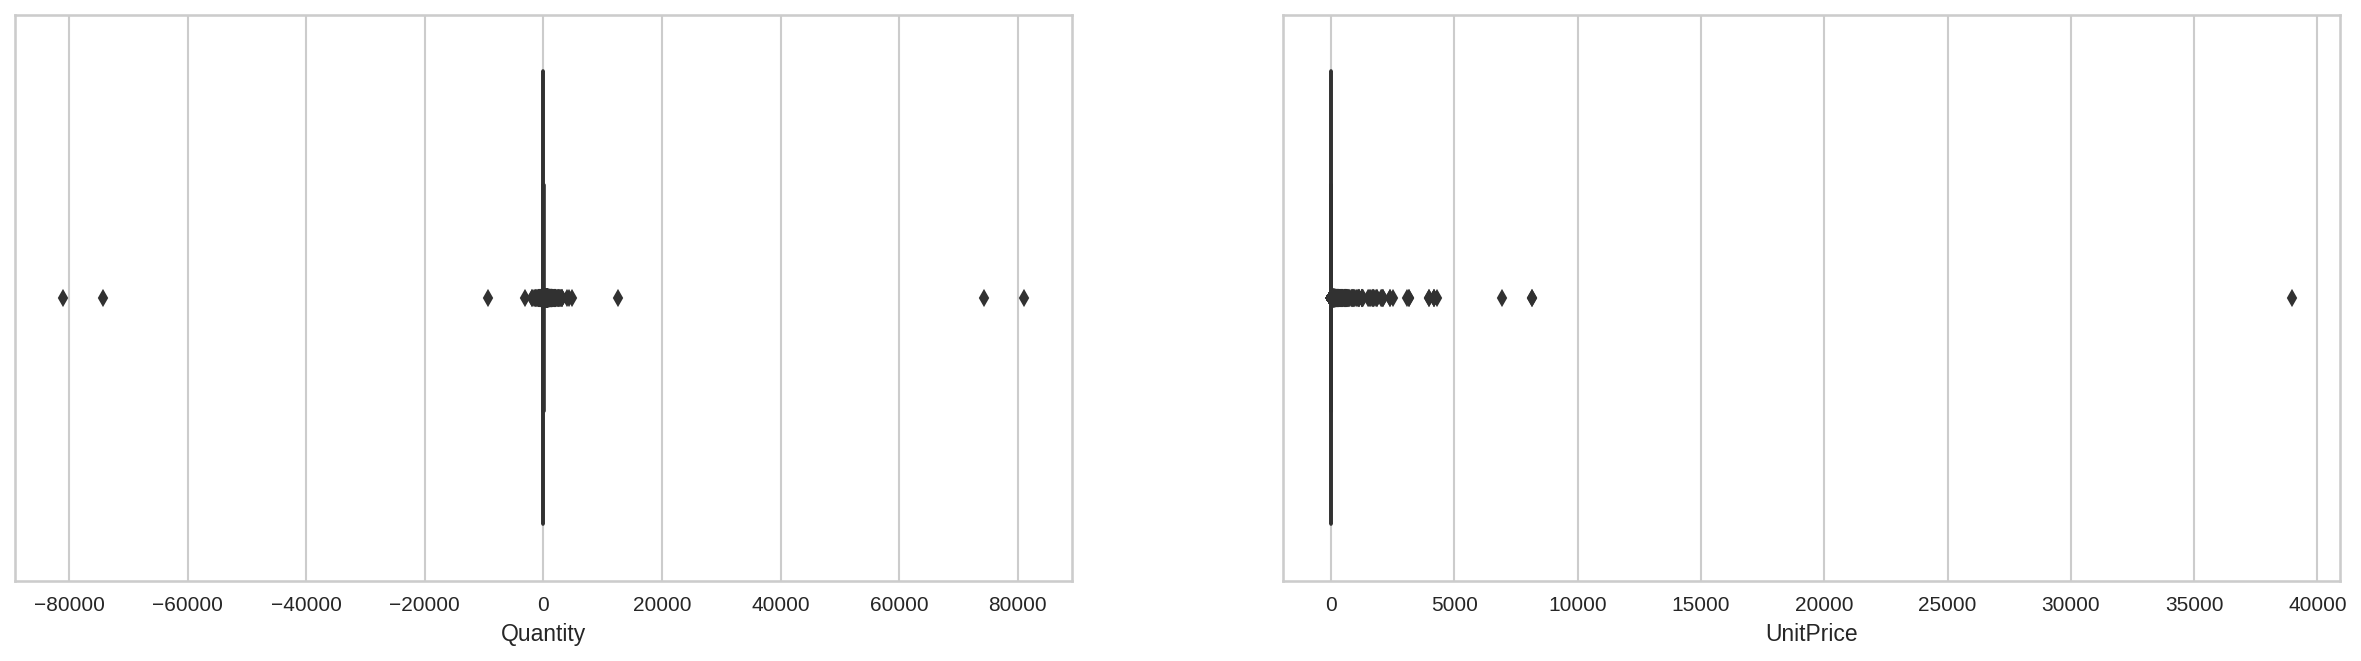

In [139]:
#Checking for outliers in the data      
for index, col in enumerate(out_cols):
  plt.subplot(1,2,index+1)
  sns.boxplot(data = cus_data,x=col)

The negative quanity represent the cancelled orders

**Feature Engineering**

In [140]:

#Finding the cancelled orders: InvoiceNo starting with 'C' represents cancellation
cus_data['InvoiceNo'] = cus_data['InvoiceNo'].astype('str') #change data typpe tp str
cancellations = cus_data[cus_data['InvoiceNo'].str.contains('C')]  #find rows contains 'C'
cancellations.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/10 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/10 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/10 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/10 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/10 10:24,0.29,17548.0,United Kingdom


In [141]:
cancellations.shape

(8872, 8)

In [142]:
# # Dropping cancellations from the main dataframe
dataset = cus_data[~cus_data.isin(cancellations)].dropna(how='all')

In [143]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/10 8:26,3.39,17850.0,United Kingdom


In [144]:
dataset.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,12/9/11 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3.0,12/9/11 12:50,4.95,12680.0,France


In [145]:
dataset.shape

(392732, 8)

Extract columns from the InvoiceDate column:

In [146]:
# convert InvoiveDate to datetime 
dataset["InvoiceDate"]=dataset["InvoiceDate"].apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))

In [147]:
# Creating new features from the datetime column InvoiceDate
dataset["year"]  = dataset["InvoiceDate"].apply(lambda x: x.year)
dataset['Month'] = dataset['InvoiceDate'].apply(lambda x: x.month_name())
dataset['Day']   = dataset['InvoiceDate'].apply(lambda x: x.day_name())
dataset["hour"]  = dataset["InvoiceDate"].apply(lambda x: x.hour)


In [148]:

# Creating a new feature 'TotalAmount' by multiplying Quantity and UnitPrice
dataset['TotalAmount'] = dataset['Quantity']*dataset['UnitPrice']


In [149]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,Month,Day,hour,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,December,Wednesday,8,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,December,Wednesday,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,December,Wednesday,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,December,Wednesday,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,December,Wednesday,8,20.34


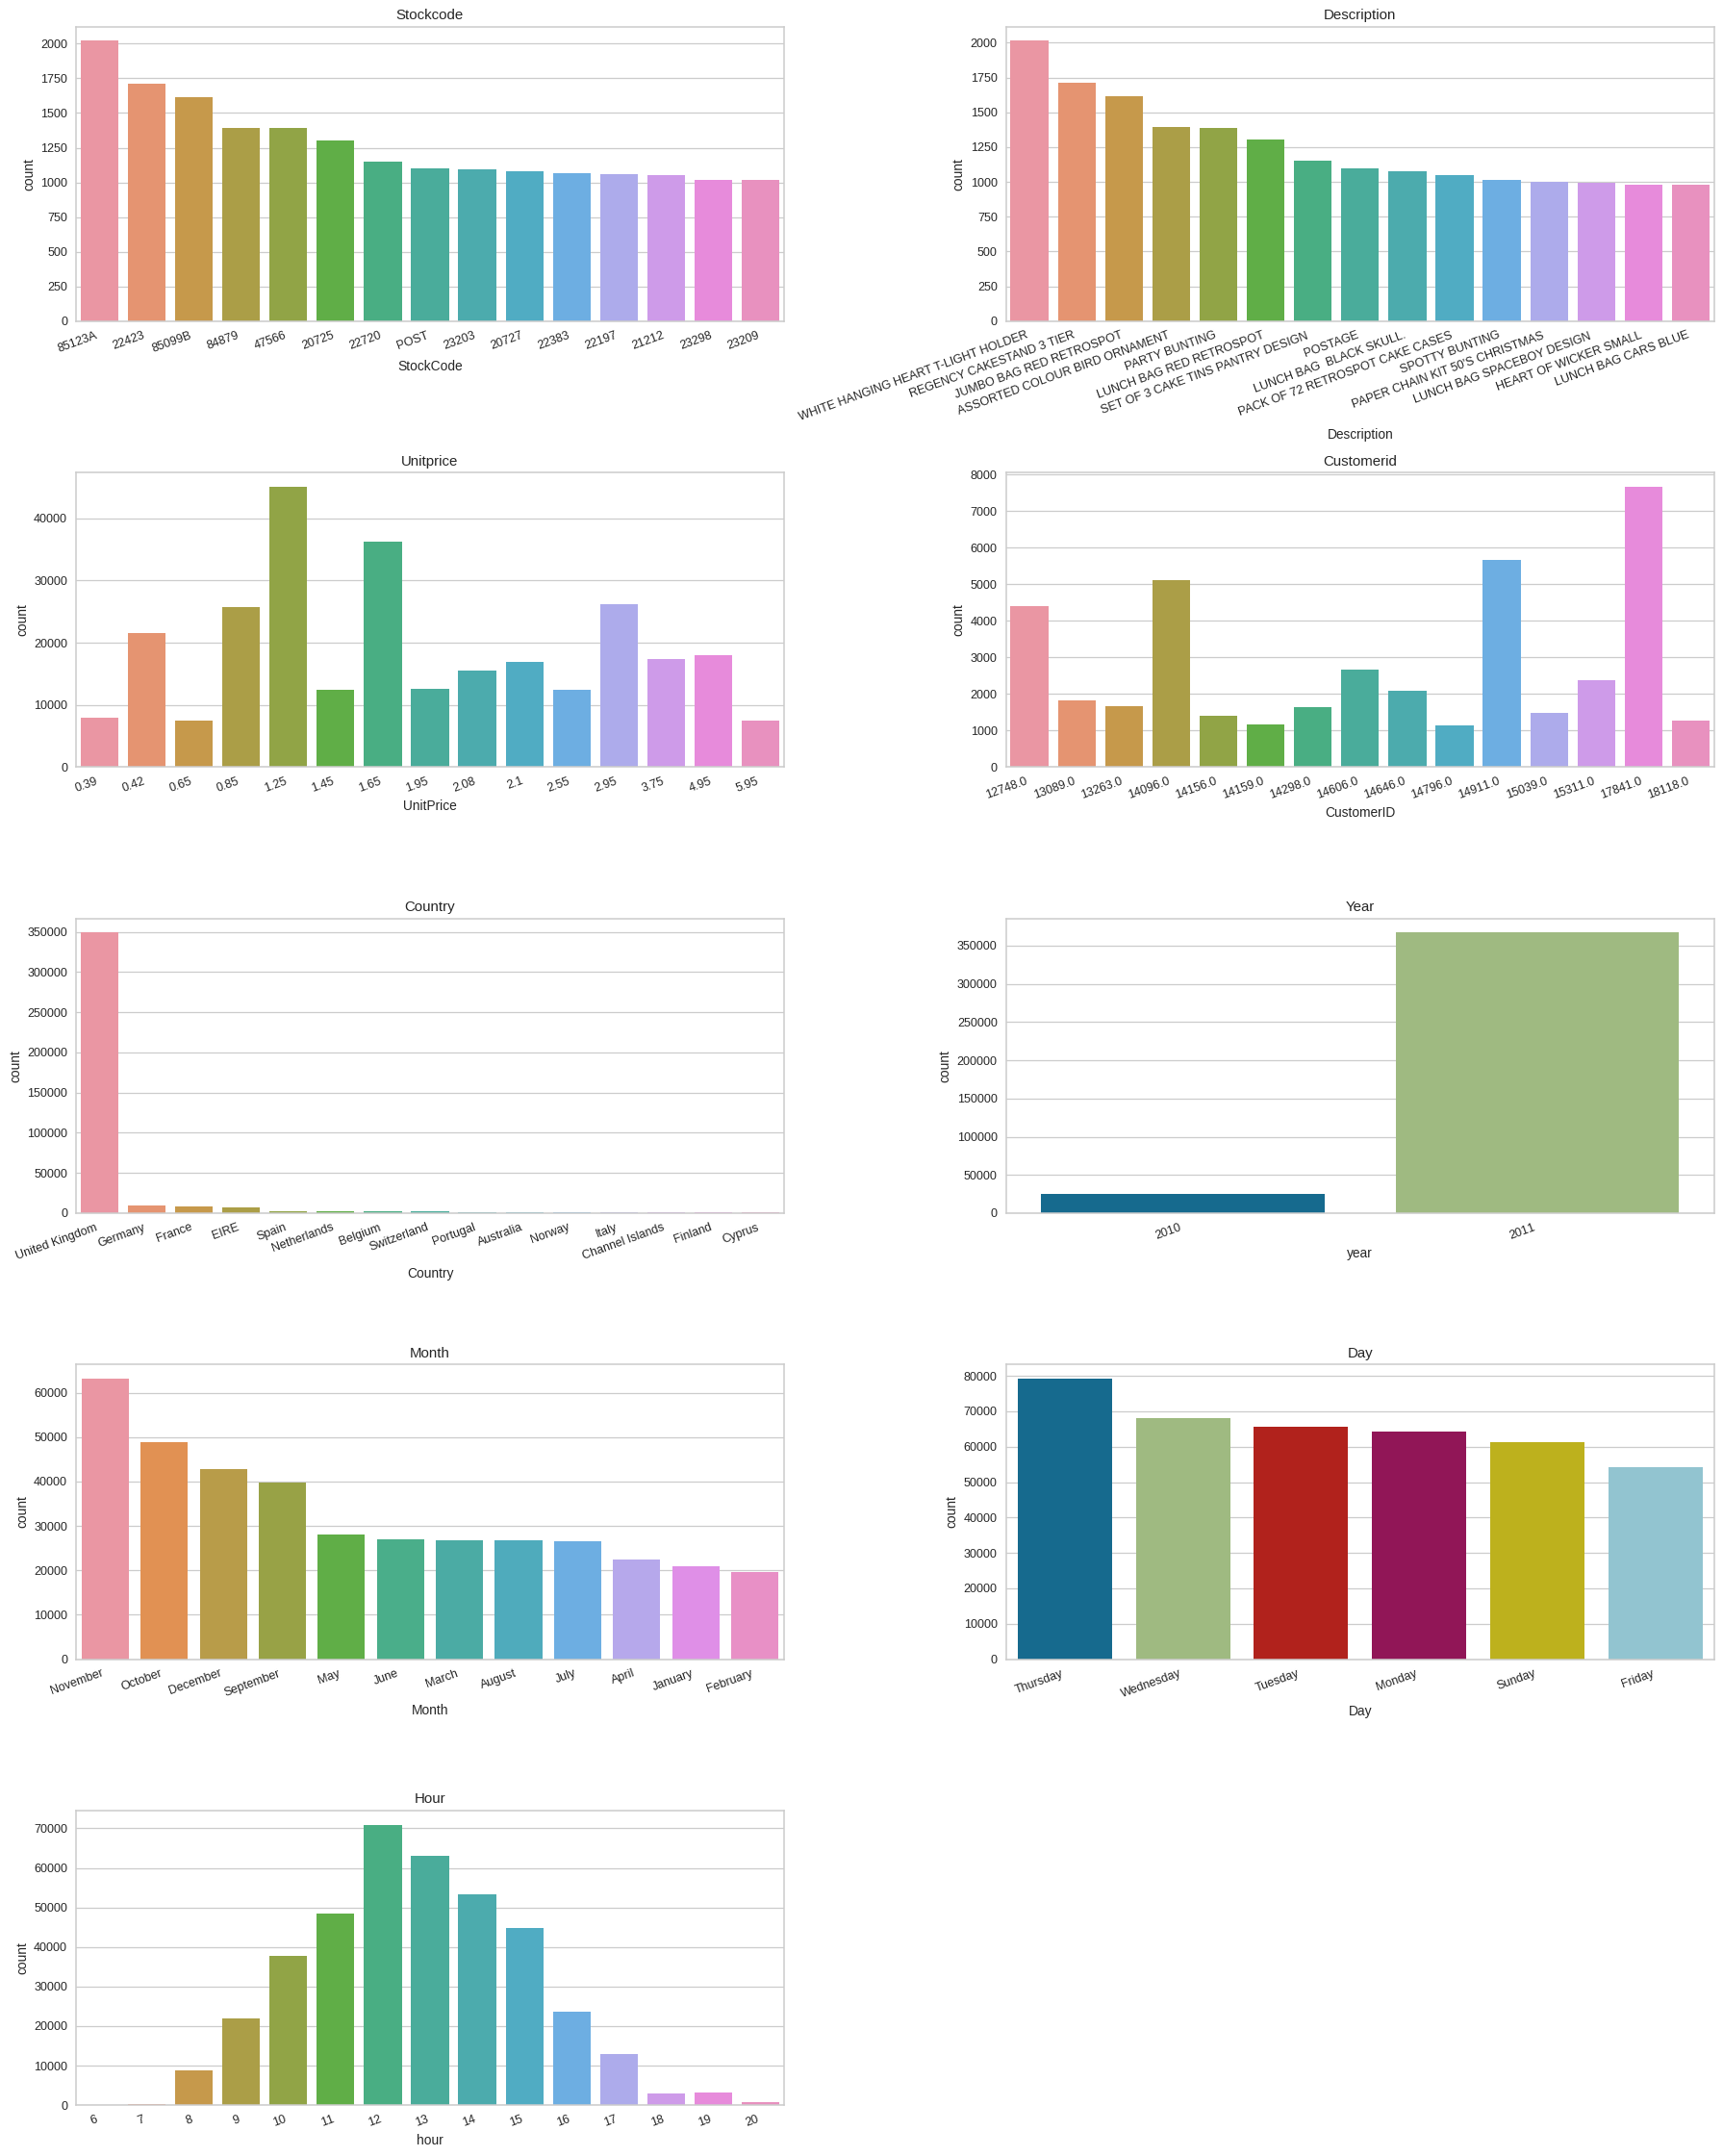

In [150]:
# Plotting top values based on frequency in each column
target = ['StockCode', 'Description','UnitPrice', 'CustomerID', 'Country',
          'year', 'Month','Day','hour']

plt.figure(figsize=(20,25), dpi=90)
for n,col in enumerate(target):
  plt.subplot(5, 2, n+1)
  temp = dataset[col].value_counts().reset_index().head(15)
  temp.rename(columns={'index': col, col:'count'}, inplace=True)
  sns.barplot(x=col ,y='count', data=temp).set(title=col.title())
  plt.xticks(rotation=20,ha='right')
  plt.tight_layout()

Observations/Hypothesis:

Most Customers are from United Kingdom. Considerable number of customers are also from Germany, France, EIRE and Spain. Whereas Saudi Arabia, Bahrain, Czech Republic, Brazil and Lithuania has least number of customers\
There are no orders placed on Saturdays. Looks like it's a non working day for the retailer.\
Most of the customers have purchased the gifts in the month of November, October, December and September. Less number of customers have purchased the gifts in the month of April, January and February.\
Most of the customers have purchased the items in Afternoon, moderate numbers of customers have purchased the items in Morning and the least in Evening.\
WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CAKESTAND 3 TIER, JUMBO BAG RED RETROSPOT are the most ordered products

In [151]:
#Creating a list of all the numerical columns in the data
numerical_columns = list(dataset.describe().columns)
numerical_columns


['Quantity', 'UnitPrice', 'CustomerID', 'year', 'hour', 'TotalAmount']

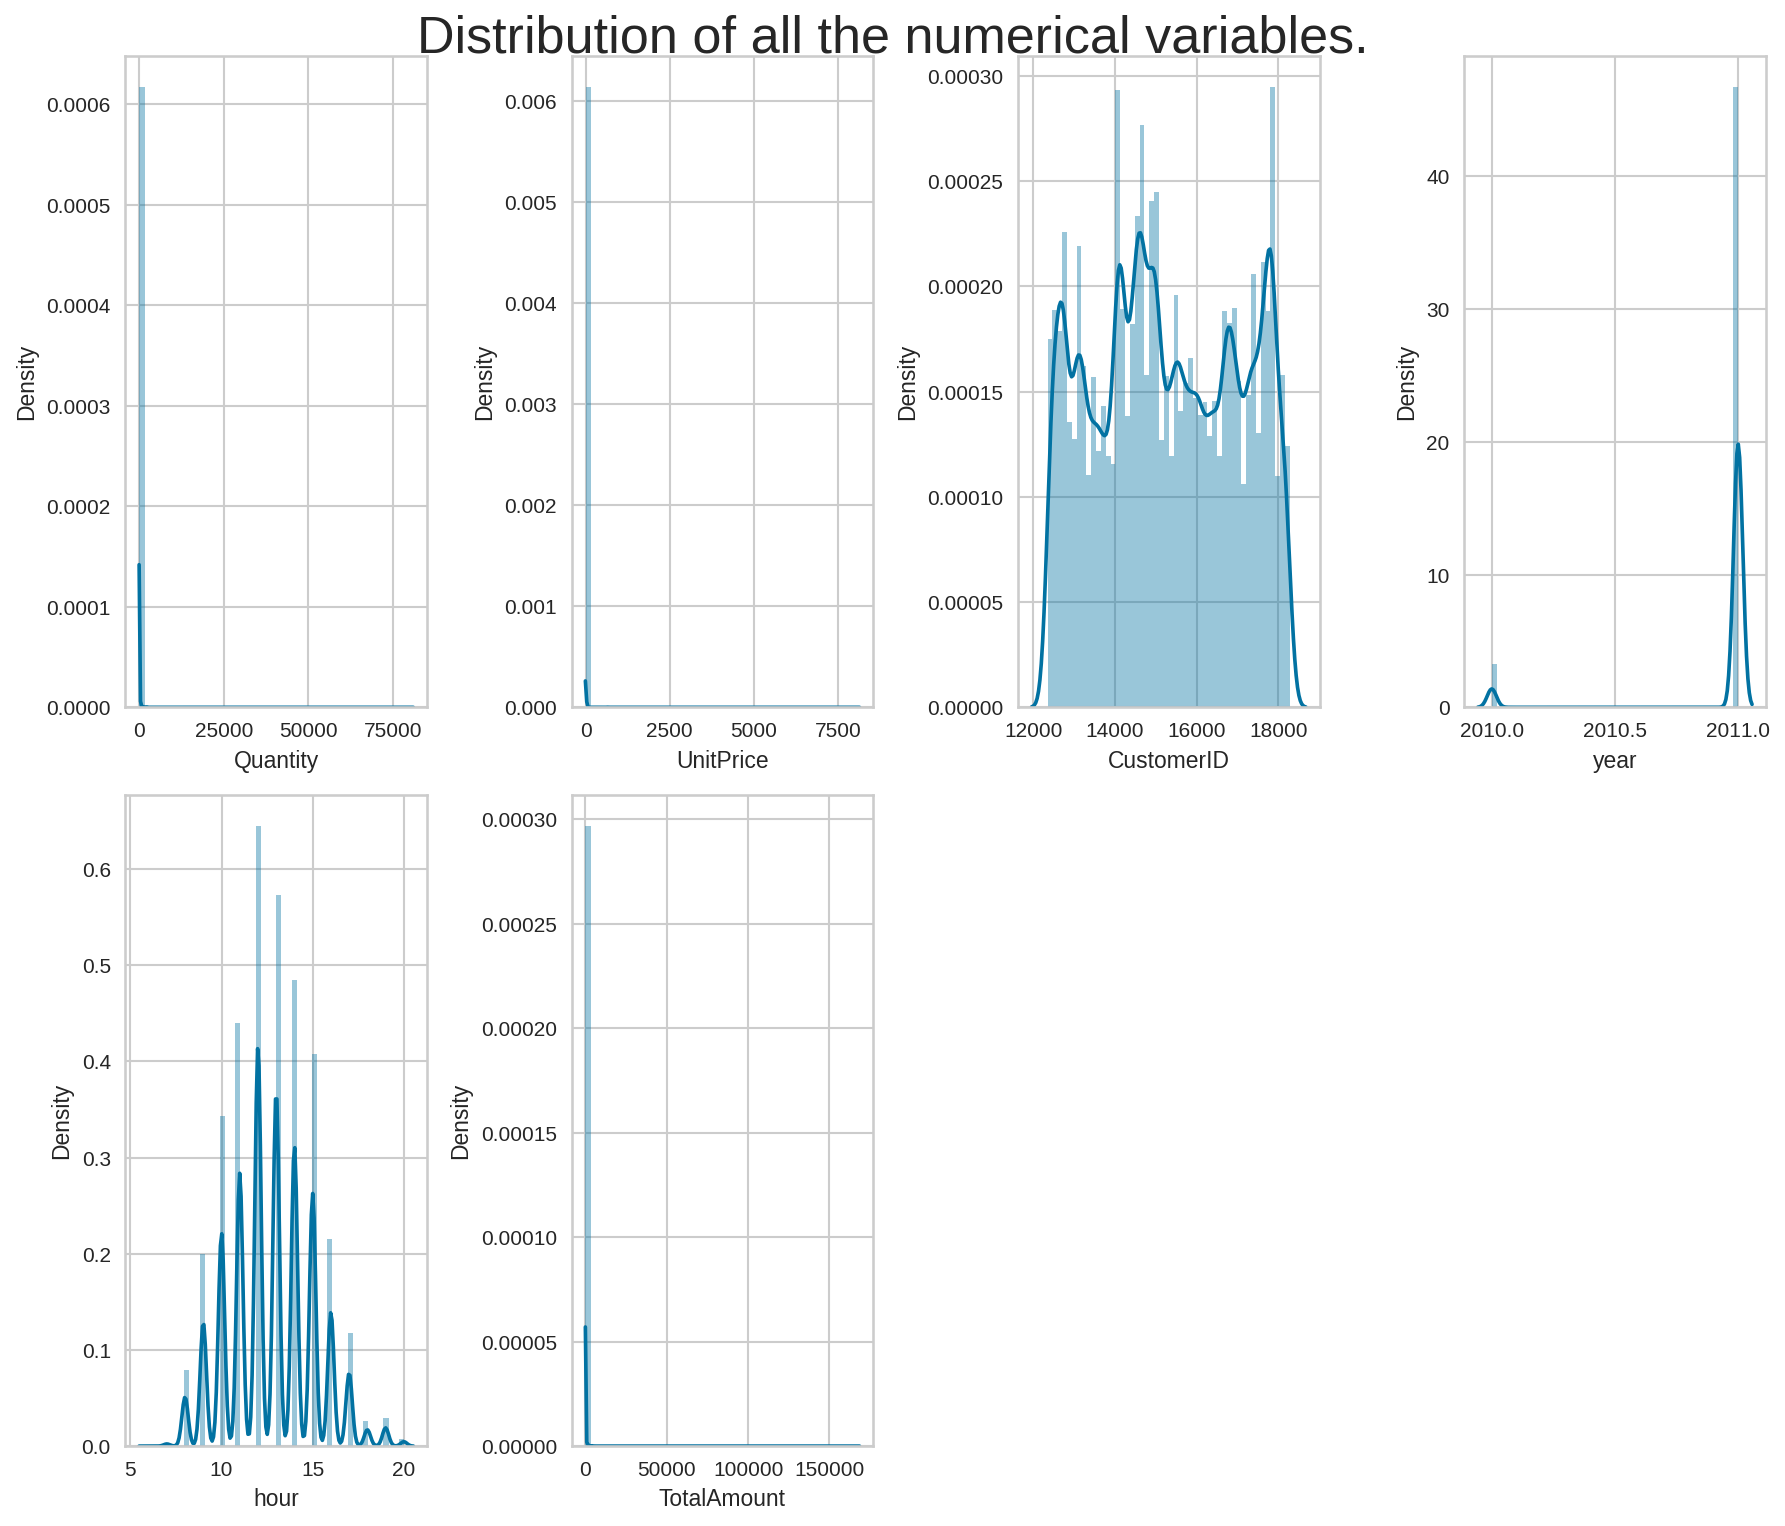

In [152]:
#Plotting the distribution of the data
plt.figure(figsize=(12,10))
plt.suptitle('Distribution of all the numerical variables.',va='bottom',size=25)
for index, item in enumerate(numerical_columns):
  plt.subplot(2,4,index+1)
  sns.distplot(dataset[item])
plt.tight_layout()


It shows a positively skewed distribution because most of the values are clustered around the left side of the distribution while the right tail of the distribution is longer, which means mean>median>mode
For symmetric graph mean=median=mode.

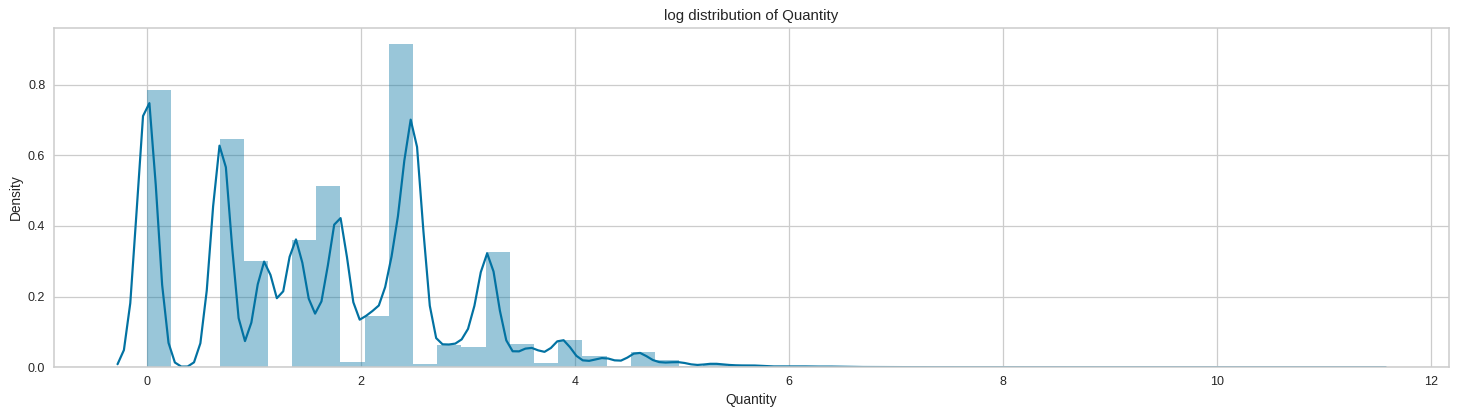

In [153]:
# Visualizing the distributions after log transformation of Quantity
plt.figure(figsize=(20,5), dpi=90)
plt.title('log distribution of Quantity')
sns.distplot(np.log(dataset['Quantity']))
plt.show()


Plotting the correlation matrix:

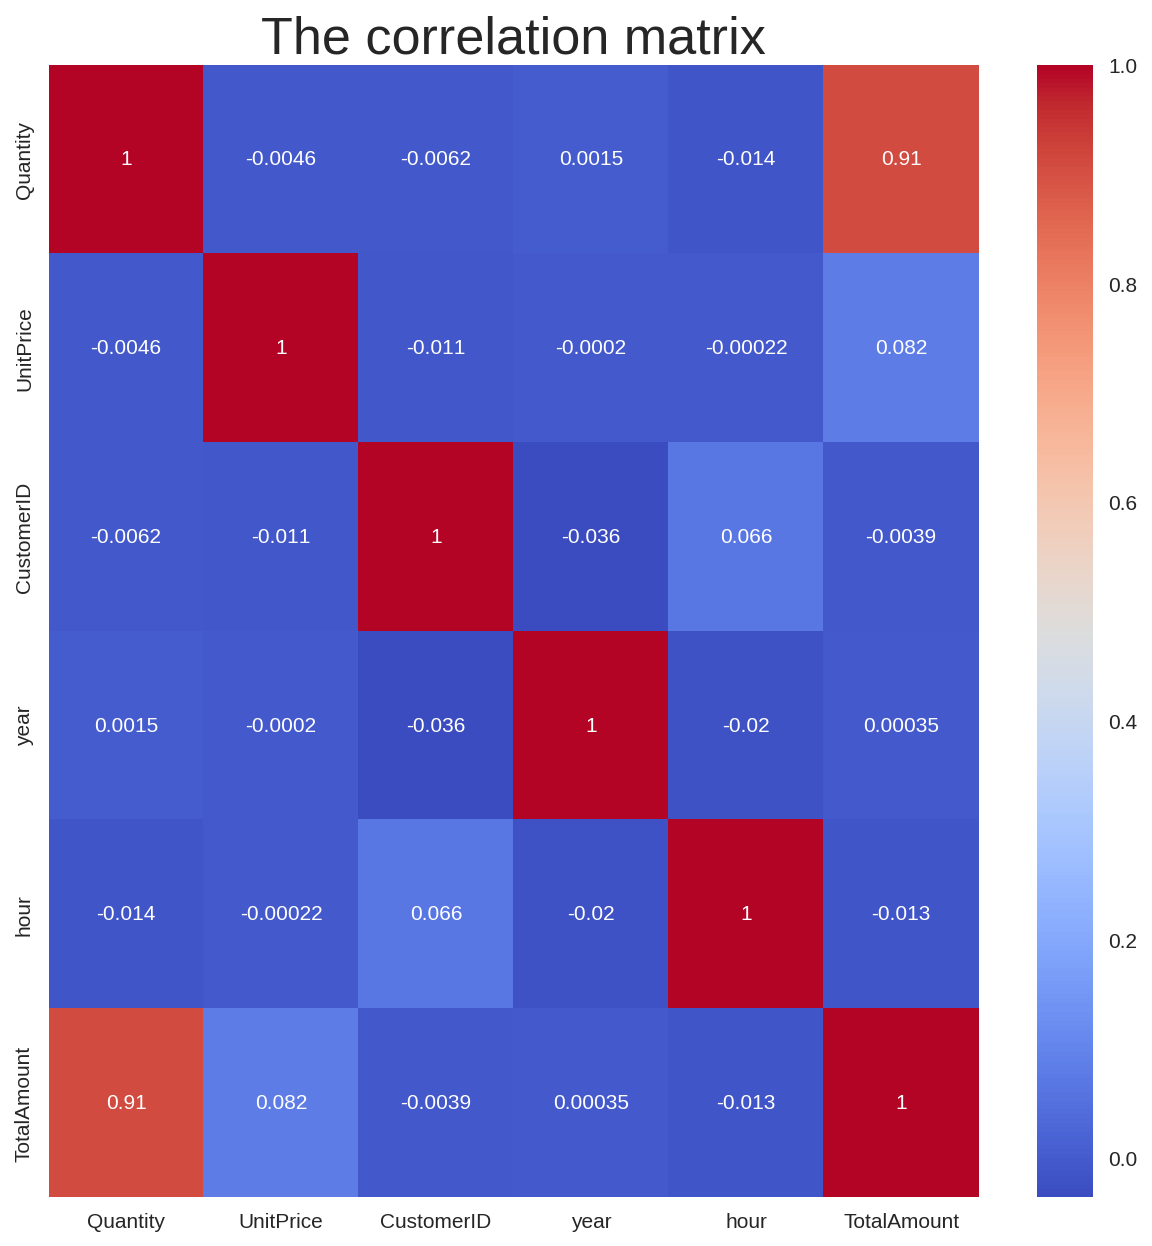

In [154]:
#Forming and plotting the correlation matrix
corr_matrix = dataset.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm')
plt.title('The correlation matrix',size=25)
plt.show()

There is no distinct correlation between the variables except for the columns 'total_amount', 'Quantity' and 'UnitPrice', which is obivious

**segmentation criteria:**

we need to cluster customers according to there activities i.e


1.   R- Recency
2.   F- Frequency
3.   M- Monetary









In [155]:
#Creating a variable to hold the latest date in the dataset
latest_date = dataset['InvoiceDate'].max()

In [156]:
#Creating a dataframe to contain the most recent date of order for each customer
recency_df = dataset.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_df.head()


,CustomerID,InvoiceDate
0,12346.0,2011-01-18 10:01:00
1,12347.0,2011-12-07 15:52:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


In [157]:

#creating a dataframe to contain the number of times a customer has ordered
frequency_df = dataset.groupby('CustomerID')['InvoiceNo'].count().reset_index()
frequency_df.head()

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [158]:
#creating a dataframe to contain the total spends of a customer
monetory_df = dataset.groupby('CustomerID')['TotalAmount'].sum().reset_index()
monetory_df.head()

,CustomerID,TotalAmount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


Interpretation:

Recency: How recent a customer made a purchase.\
Frequency: How often a customer makes a purchase.\
Monetary: How much money a customer spends.

In [159]:

#Creating a dataframe for the RFM model
rfm_df = pd.DataFrame()
rfm_df['CustomerID'] = recency_df['CustomerID']
rfm_df['Recency'] = recency_df['InvoiceDate'].apply(lambda x: (latest_date-x).days)
rfm_df['Frequency'] = frequency_df['InvoiceNo']
rfm_df['Monetary'] = monetory_df['TotalAmount']

In [160]:

#Setting the CustomerID as the index
rfm_df.set_index('CustomerID',inplace=True)

#First 10 observations of the RFM dataframe
rfm_df.head(10)

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40
12352.0,35,85,2506.04
12353.0,203,4,89.00
12354.0,231,58,1079.40
12355.0,213,13,459.40


In [161]:

# Calculating R, F and M scores by splitting Recency, Frequency	and Monetary based on quantiles
rfm_df['R'] = pd.qcut(rfm_df['Recency'], q=4, labels=[4,3,2,1]).astype(int)
rfm_df['F'] = pd.qcut(rfm_df['Frequency'], q=4, labels=[1,2,3,4]).astype(int)
rfm_df['M'] = pd.qcut(rfm_df['Monetary'], q=4, labels=[1,2,3,4]).astype(int)

# Finding the RFM Group for each customer by combining the factors R,Fand M
rfm_df['RFM'] = 100*rfm_df['R'] + 10*rfm_df['F'] + rfm_df['M']

# Finding the RFM Score for each customer by adding the factors R,Fand M
rfm_df['RFM_Score'] = rfm_df['R'] + rfm_df['F'] + rfm_df['M']

Interpretation:

If the RFM of any customer is 444. His Recency is good, frequency is more and Monetary is more. So, he is the best customer.\
If the RFM of any customer is 111. His Recency is low, frequency is low and Monetary is low. So, he is the churning customer.\
If the RFM of any customer is 144. He purchased a long time ago but buys frequently and spends more. And so on.\
Like this we can come up with number of segments for all combinations of R,F and M base on our usecase. Higher the RFM score, more valuable the customer is.

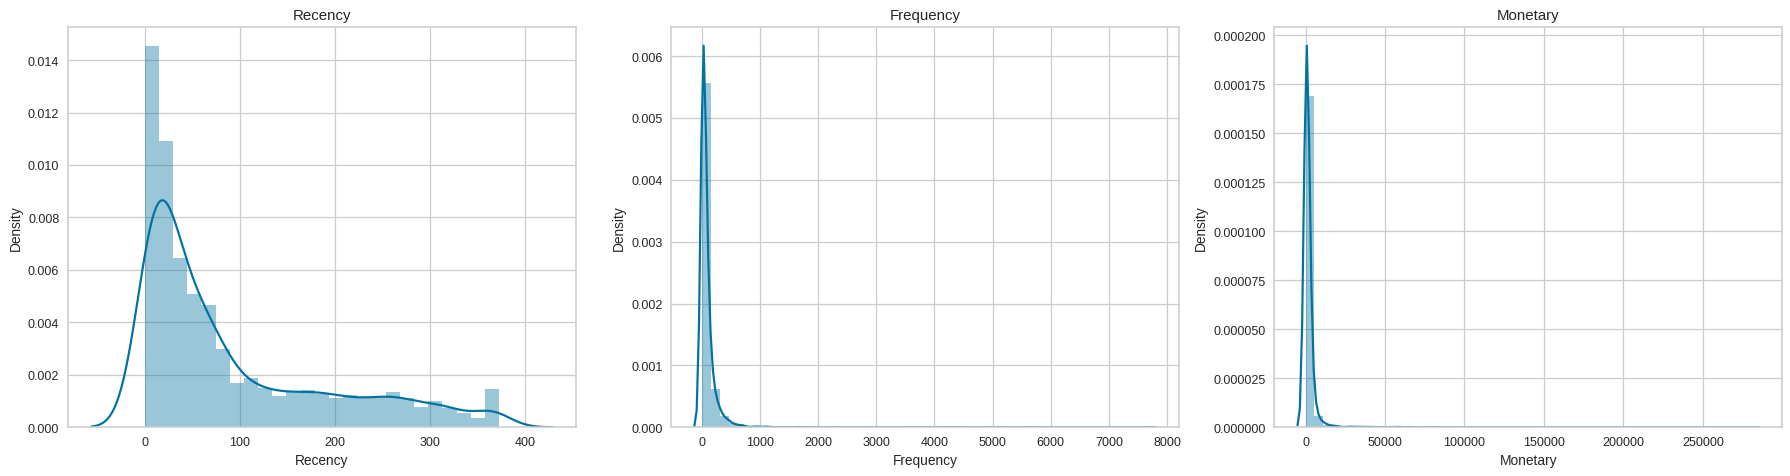

In [162]:
target = ['Recency', 'Frequency',	'Monetary']
plt.figure(figsize=(20,10), dpi=90)
for n,col in enumerate(target):
  plt.subplot(2, 3, n+1)
  sns.distplot(rfm_df[col])
  plt.title(col.title())
  plt.tight_layout()

Distributions of Recency, Frequency and Monetary columns are positively skewed\
This is indication of outliers

In [163]:
# Handling the zeroes in the dataframe to avoid error in transformations
rfm_df.replace(0.0,1,inplace=True)

In [164]:
# Applying Log transformation on columns for smoothening the distribution
rfm_df['Recency_Log']   = rfm_df['Recency'].apply(np.log)
rfm_df['Frequency_Log'] = rfm_df['Frequency'].apply(np.log)
rfm_df['Monetary_Log']  = rfm_df['Monetary'].apply(np.log)
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score,Recency_Log,Frequency_Log,Monetary_Log
CustomerID,,,,,,,,,,,
12346.0,325,1,77183.60,1,1,4,114,6,5.783825,0.000000,11.253942
12347.0,1,182,4310.00,4,4,4,444,12,0.000000,5.204007,8.368693
12348.0,74,31,1797.24,2,2,4,224,8,4.304065,3.433987,7.494007
12349.0,18,73,1757.55,3,3,4,334,10,2.890372,4.290459,7.471676
12350.0,309,17,334.40,1,1,2,112,4,5.733341,2.833213,5.812338


In [165]:

# Checking Descriptive Stats
rfm_df.describe()

,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score,Recency_Log,Frequency_Log,Monetary_Log
count,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000
mean,91.539756,90.512100,2048.216154,2.514174,2.487670,2.499885,278.793962,7.501729,3.706757,3.670868,6.584187
std,99.990232,225.515328,8984.248299,1.126392,1.122724,1.118266,118.825268,2.816451,1.512315,1.321685,1.265573
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,111.000000,3.000000,0.000000,0.000000,0.000000
25%,17.000000,17.000000,306.455000,2.000000,1.000000,1.500000,211.000000,5.000000,2.833213,2.833213,5.725071
50%,50.000000,41.000000,668.560000,3.000000,2.000000,2.000000,311.000000,7.000000,3.912023,3.713572,6.505126
75%,141.000000,98.000000,1660.315000,4.000000,3.000000,3.500000,411.000000,10.000000,4.948760,4.584967,7.414763
max,373.000000,7676.000000,280206.020000,4.000000,4.000000,4.000000,444.000000,12.000000,5.921578,8.945854,12.543280


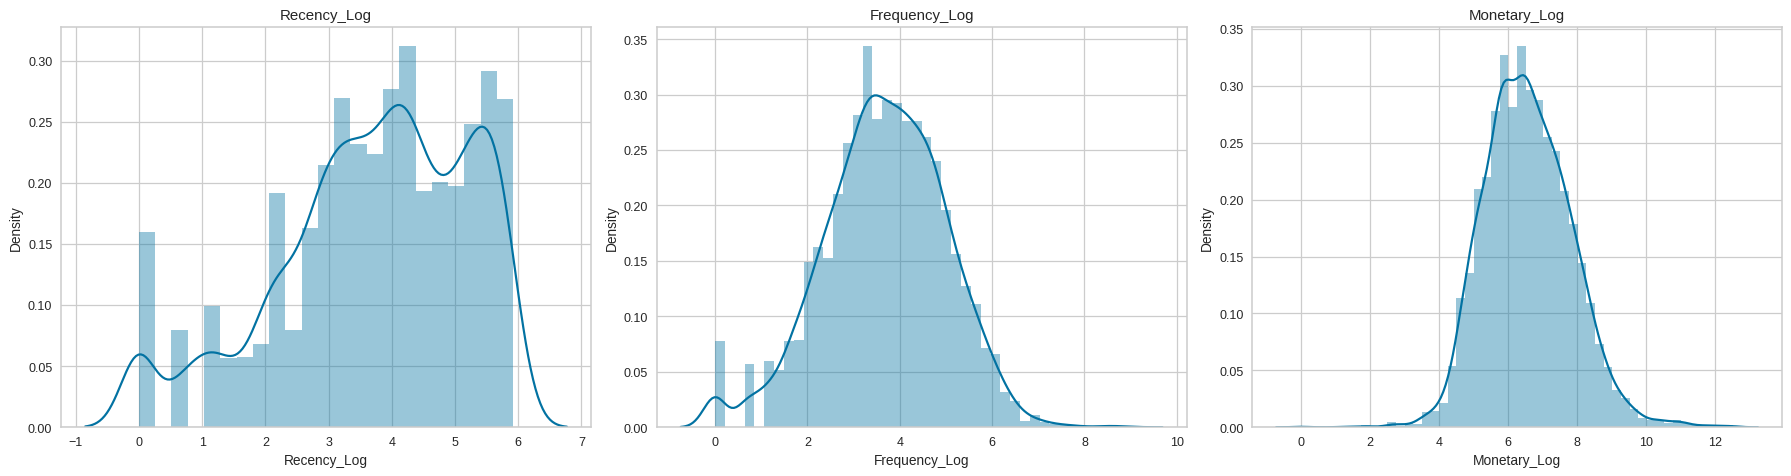

In [166]:
# Visualizing the distributions before and after log transformation.
target = ['Recency_Log', 'Frequency_Log', 'Monetary_Log']
plt.figure(figsize=(20,10), dpi=90)
for n,col in enumerate(target):
  plt.subplot(2, 3, n+1)
  sns.distplot(rfm_df[col])
  plt.title(col.title())
  plt.tight_layout()

The transformed  distributions appear to be symmetrical and normally distributed

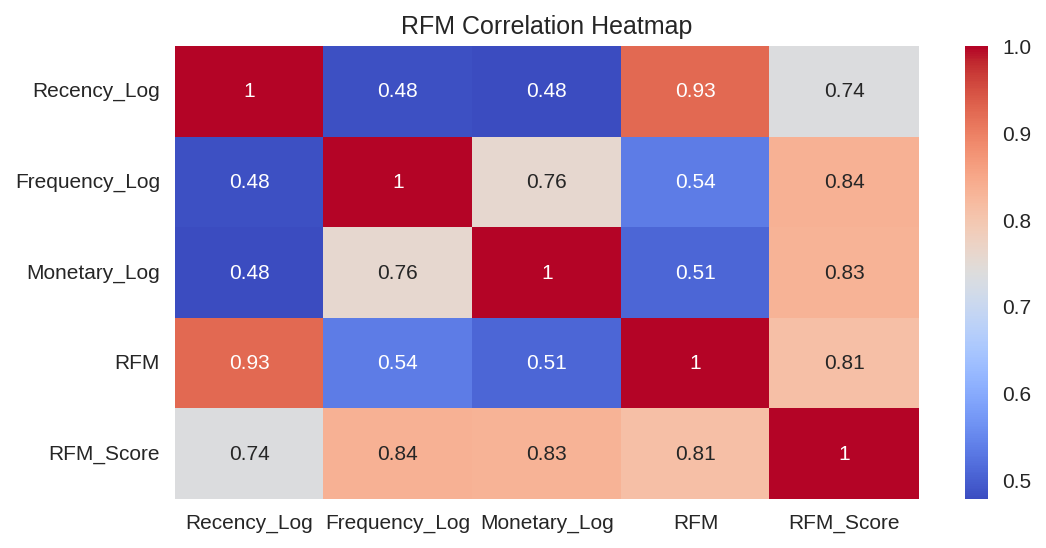

In [167]:

# Visualizing the correlations among features.
target = ['Recency_Log','Frequency_Log','Monetary_Log','RFM','RFM_Score']
plt.figure(figsize = (8, 4), dpi=150)
sns.heatmap(abs(rfm_df[target].corr()), annot=True, cmap='coolwarm')
plt.title('RFM Correlation Heatmap')
plt.show()


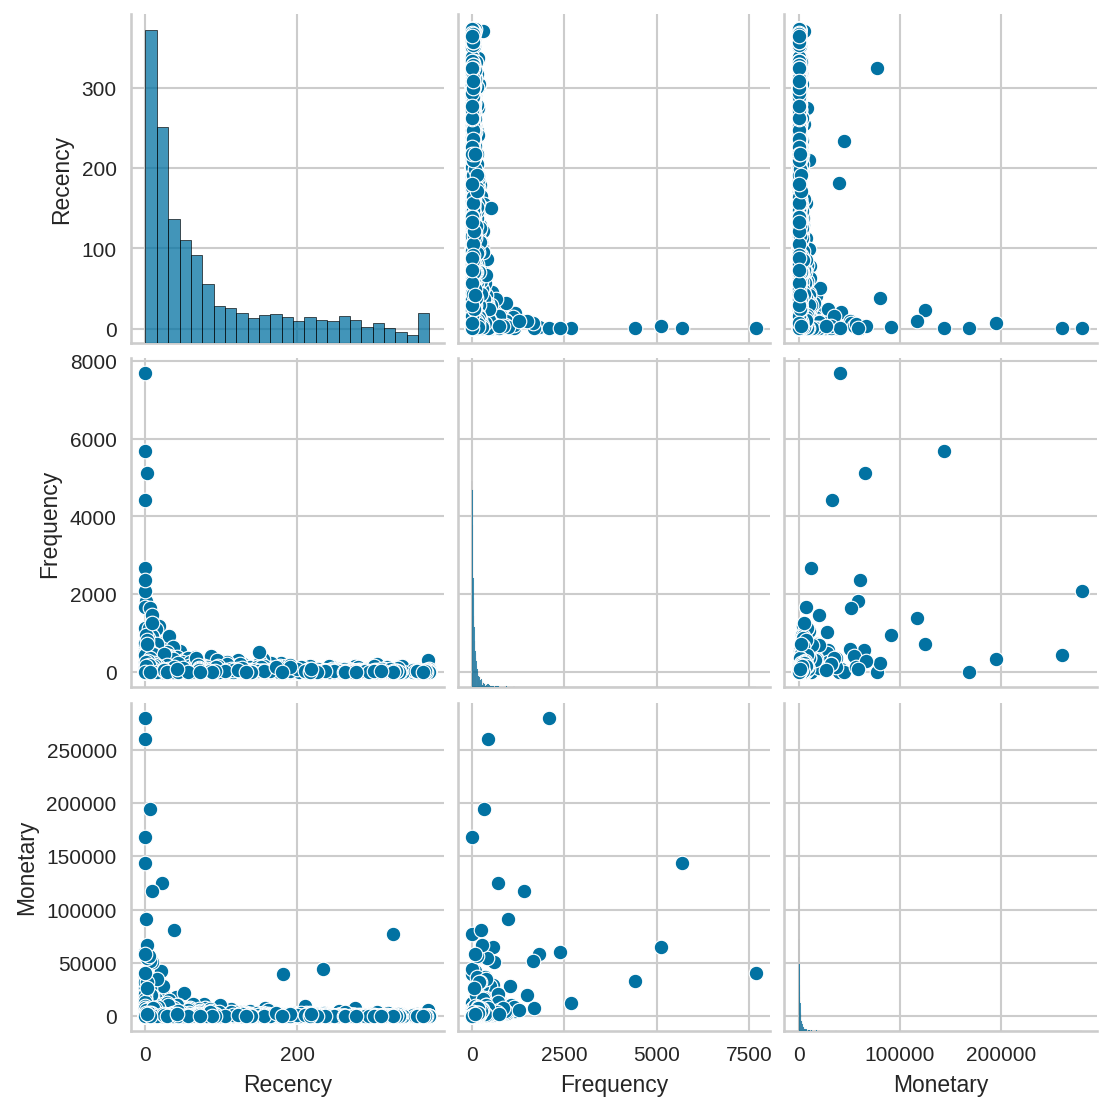

In [170]:
#plotting the pairplot to see the relation bewteen the columns of the RFM dataframe
sns.pairplot(rfm_df[['Recency', 'Frequency',	'Monetary']])
plt.show()


Most of the values are linked to lower recency values.\
Very few values linked to a large recency value and large monetary/frequency value.\
There is alinear relationship with Frequency and Monetory column

Preprocessing Data